In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib


import pybedtools as bt

from collections import Counter, deque
import pickle
import re
import os

from mycolorpy import colorlist as mcp
import matplotlib.patches as mpatches
import matplotlib.collections as mcol
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from matplotlib_venn import venn3, venn2


from matplotlib import gridspec
from scipy.stats import shapiro, mannwhitneyu, iqr,spearmanr, ttest_rel, ttest_ind, fisher_exact, chisquare, pearsonr, ranksums
from statsmodels.stats.multitest import multipletests 
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix,roc_auc_score,RocCurveDisplay, roc_curve

import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt

from adjustText import adjust_text

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
import statsmodels.api as sm
from glmnet import ElasticNet,LogitNet

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-7:-2]
color3=mcp.gen_color(cmap="Blues",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
color5=mcp.gen_color(cmap="Purples",n=10)[-7:-2]



def flatten(l):
    return [item for sublist in l for item in sublist]

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

        
def change_height(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)


def get_aster(p):
    if p <= 0.0001:
        aster= "****"
    elif p <= 0.001:
        aster= "***"
    elif p <= 0.01:
        aster= "**"
    elif p <= 0.05:
        aster= "*"
    else:
        aster= 'ns'
    return aster


colorPalette = {
    "ANDR"    : color1[-1],
    "High"    : color2[-1],
    "Mid-high": color2[-1],
    "Mid-low" : color2[-1],
    "low"     : color2[-1],
    
    "ARcre"   : "#F19323",
    "cre"     : "#888888",
}

MAPty = pickle.load(open('../data/pickle/MAPty.p', 'rb'))
MAPcl = pickle.load(open('../data/pickle/MAPcl.p', 'rb'))
MAPgn = pickle.load(open('../data/pickle/MAPgn.p', 'rb'))


BEDPRO = pickle.load(open('../data/pickle/BEDPRO.p', 'rb'))
BEDPRO['LFC_16h'] = np.log2((BEDPRO['16h']+1) / (BEDPRO['Vh']+1))
cols = list(BEDPRO.columns)
BEDPRO = BEDPRO.sort_values('LFC_16h', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index':'LFC_16h_rank'}).sort_values(['Chr', 'Start']).reset_index(drop=True).loc[:, cols+['LFC_16h_rank']]

GENES = dict(zip(BEDPRO['Gene'], BEDPRO['Name']))

# N contains BW signal for RNA seq but BEDPRO contains  
N = pd.read_table('../data/TABLE/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_Vh'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['Vh'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_30m'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['30m'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_4h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['4h'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_16h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['16h'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_72h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['72h'])))

T = pd.read_table('../data/TABLE/TF.tmm.tsv').set_index('Name').drop_duplicates()
T = pd.read_table('../data/TABLE/TF.CA.tmm.tsv').set_index('Name').drop_duplicates()
L = pd.read_table('../data/TABLE/TF.LFC.tsv').set_index('Name').drop_duplicates()
M = pd.read_table('../data/TABLE/TF.NEW.tsv').set_index('Name').drop_duplicates()
S = pd.read_table('../data/TABLE/STAR.tsv').set_index('Name').drop_duplicates()
#R = pd.read_table('../data/TABLE/LR.RPKM.tsv').drop_duplicates().set_index('Name')
R = pd.read_table('../data/TABLE/LR.A_sum.tsv').drop_duplicates().set_index('Name')
#R = pd.read_table('../data/TABLE/LR.RPKM.tsv').drop_duplicates().set_index('Name')

H = pickle.load(open('../data/G/G_ALL.p', 'rb'))
#A = np.array(nx.adjacency_matrix(H).todense())

def quantileNormalize(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

    
BEDPES_H3K27ac = {}
for i, h in  enumerate(["Vh", "30m","4h", "16h", "72h"]):
    BEDPES_H3K27ac[h] = bt.BedTool(f"../data/BEDPE/ALL_H3K27ac_{h}.tmm.bedpe")

BEDPES_H3K4me3 = {}
for i, h in  enumerate(["Vh", "30m","4h", "16h", "72h"]):
    BEDPES_H3K4me3[h] = bt.BedTool(f"../data/BEDPE/ALL_H3K4me3_{h}.tmm.bedpe")
    
    
sns.set(font_scale=2, style='ticks')

def znorm(a):
    return (a - a.mean()) / a.std()

times = ['Vh', '30m', '4h', '16h', '72h']
    


In [2]:
df = pd.read_table('freedmanCRISPRi_ALL2.tsv')


df['E'] = df['ARBS.chr'] + ':' + df['ARBS.start'].astype(str) + '-' + df['ARBS.stop'].astype(str)
df = df.groupby(['Gene', 'E']).mean().reset_index()
#df = df[~df['E'].isin(['chr8:23537929-23542929'])]

df 

#NKX3-1 : chr8:23537929-23542929 : promoter

,Gene,E,Gene.start,Gene.stop,ARBS.start,ARBS.stop,H3K27ac.Vh,H3K27ac.30m,H3K27ac.4h,H3K27ac.16h,H3K27ac.72h,H3K4me3.Vh,H3K4me3.30m,H3K4me3.4h,H3K4me3.16h,H3K4me3.72h,distance,CRISPRi
0,ABCC4,chr13:95896501-95901501,95951183.0,95956183.0,95896501.0,95901501.0,1.763087,4.138536,3.204949,4.033821,3.420827,1.692175,2.049492,3.169120,2.126320,1.099412,54682.0,0.967050
1,ABCC4,chr13:95917889-95922889,95951183.0,95956183.0,95917889.0,95922889.0,4.995414,8.097136,10.042173,14.224527,9.999341,3.102321,6.490058,7.843572,5.799054,4.947356,33294.0,1.013794
2,ABCC4,chr13:95921252-95926252,95951183.0,95956183.0,95921252.0,95926252.0,4.995414,8.097136,10.042173,14.224527,9.999341,3.102321,6.490058,7.843572,5.799054,4.947356,29931.0,0.833894
3,DHCR24,chr1:55345858-55350858,55350391.0,55355391.0,55345858.0,55350858.0,25.564768,44.624214,37.604733,94.900951,52.364969,28.484945,33.816620,47.457574,42.139796,19.514571,4533.0,0.635794
4,DHCR24,chr1:55368298-55373298,55350391.0,55355391.0,55368298.0,55373298.0,3.232327,7.917199,5.768908,10.615319,4.999670,9.588991,8.197969,14.894865,8.891884,5.771915,-17907.0,0.966554
5,KLK2,chr19:51370076-51375076,51374195.0,51379195.0,51370076.0,51375076.0,48.484905,51.281859,95.934802,93.414807,38.681661,8.178846,8.539551,8.239712,19.330182,6.046769,4119.0,0.435665
6,KLK2,chr19:51390631-51395631,51374195.0,51379195.0,51390631.0,51395631.0,15.573939,21.952234,38.245723,23.566008,10.788763,2.538262,2.049492,2.931436,12.371316,4.122797,-16436.0,0.638602
7,KLK3,chr19:51342895-51347895,51355671.0,51360671.0,51342895.0,51347895.0,24.977072,23.571661,46.578590,26.750604,12.367606,4.794496,4.098984,5.704416,7.732073,3.847944,12776.0,0.606370
8,KLK3,chr19:51352016-51357016,51355671.0,51360671.0,51352016.0,51357016.0,30.560183,50.202241,89.738568,95.962483,32.892569,10.153050,11.613789,11.250377,25.129236,5.497062,3655.0,0.369333
9,KLK3,chr19:51370076-51375076,51355671.0,51360671.0,51370076.0,51375076.0,19.687810,21.952234,43.373641,25.476765,8.157357,3.384350,4.782148,4.595224,11.598109,3.573091,-14405.0,0.405429


/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ualtintas/miniconda/envs/notebook/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.22, 1.0818252272165143)

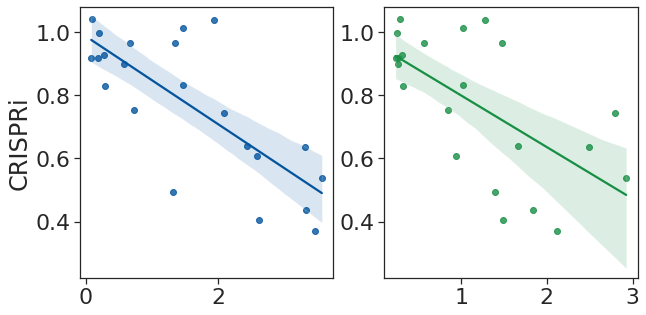

In [14]:
fig = plt.figure(figsize=[10,5])

gs = gridspec.GridSpec(nrows=1, ncols=2)

fig.add_subplot(gs[0])

x = np.log(1+df[['H3K27ac.Vh', 'H3K27ac.30m', 'H3K27ac.4h', 'H3K27ac.16h', 'H3K27ac.72h']].std(1))
y = df['CRISPRi']

sns.regplot(x, y, color='#04559F')
plt.ylim((0.22, 1.0818252272165143))
plt.xlabel('')
fig.add_subplot(gs[1])

x = np.log(1+df[['H3K4me3.Vh', 'H3K4me3.30m', 'H3K4me3.4h', 'H3K4me3.16h', 'H3K4me3.72h']].std(1))
y = df['CRISPRi']

sns.regplot(x, y, color='#188F45')

plt.ylabel('')
plt.xlabel('')


fig.savefig('../plots/SCATTER_CRISPRi.pdf', bbox_inches ="tight",  pad_inches = 1 )

plt.ylim((0.22, 1.0818252272165143))
plt.gca().get_ylim()

In [15]:
x = np.log(1+df[['H3K27ac.Vh', 'H3K27ac.30m', 'H3K27ac.4h', 'H3K27ac.16h', 'H3K27ac.72h']].std(1))
y = df['CRISPRi']

print(spearmanr(x, y))


x = np.log(1+df[['H3K4me3.Vh', 'H3K4me3.30m', 'H3K4me3.4h', 'H3K4me3.16h', 'H3K4me3.72h']].std(1))
y = df['CRISPRi']

print(spearmanr(x, y))

SignificanceResult(statistic=-0.6930245969661647, pvalue=0.0003495772262861794)
SignificanceResult(statistic=-0.6207286324904767, pvalue=0.002052286782527267)


In [4]:
H.get_edge_data(GENES['ABCC4'], 'chr13:95917889-95922889')

{'H3K27ac.Vh': 4.995414450585409,
 'H3K27ac.30m': 8.097135590330883,
 'H3K27ac.4h': 10.04217305093044,
 'H3K27ac.16h': 14.224527378813608,
 'H3K27ac.72h': 9.999340872442447,
 'H3K4me3.Vh': 3.102320717550004,
 'H3K4me3.30m': 6.490058426364508,
 'H3K4me3.4h': 7.843572389394569,
 'H3K4me3.16h': 5.799054487392282,
 'H3K4me3.72h': 4.947356124554542}

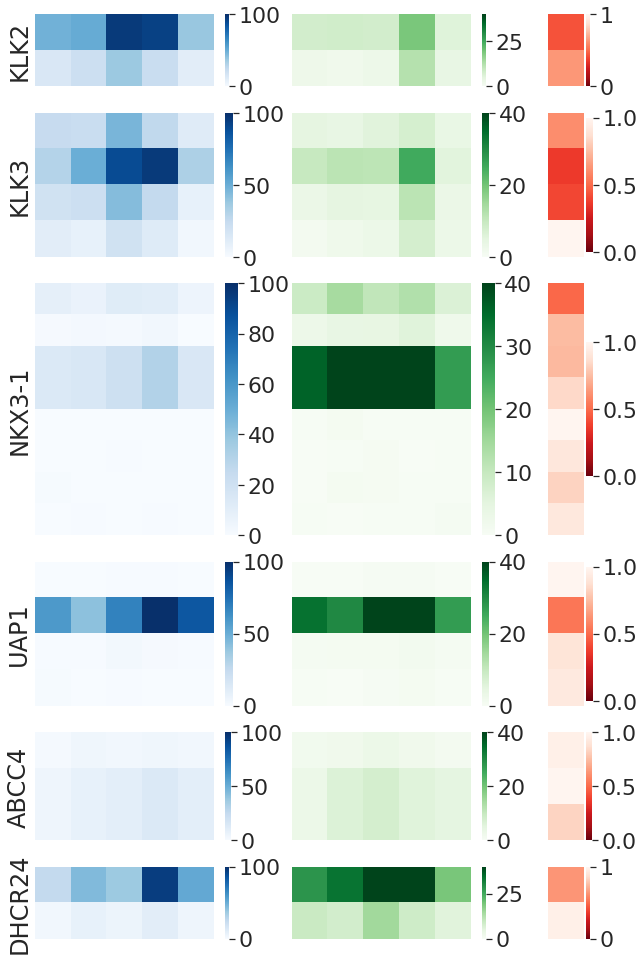

In [10]:
fig = plt.figure(figsize=[10,17])
gs = gridspec.GridSpec(nrows=6, ncols=3, width_ratios=[5,5,1], height_ratios=[2,4,7,4,3,2])

genes = ['KLK2', 'KLK3', 'NKX3-1', 'UAP1', 'ABCC4', 'DHCR24']

for i, gene in enumerate(genes):
    fig.add_subplot(gs[i, 0])
    sns.heatmap(df.loc[df['Gene'] == gene, ['H3K27ac.Vh', 'H3K27ac.30m', 'H3K27ac.4h', 'H3K27ac.16h', 'H3K27ac.72h']], cmap='Blues', vmin=0, vmax=100)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(gene)
    fig.add_subplot(gs[i, 1])
    sns.heatmap(df.loc[df['Gene'] == gene, ['H3K4me3.Vh', 'H3K4me3.30m', 'H3K4me3.4h', 'H3K4me3.16h', 'H3K4me3.72h']], cmap='Greens', vmin=0,  vmax=40)
    plt.xticks([])
    plt.yticks([])
    fig.add_subplot(gs[i, 2])
    sns.heatmap(df.loc[df['Gene'] == gene, ['CRISPRi']], cmap='Reds_r', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

fig.savefig('../plots/FINAL_CRISPRi.pdf', bbox_inches ="tight",  pad_inches = 1 )